In [ ]:
import os
import torch
import random
import numpy as np
from omegaconf import OmegaConf
from torchmetrics.segmentation import DiceScore
from torchmetrics.classification import BinaryJaccardIndex
import matplotlib.pyplot as plt
import sys
import os
import cv2
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from mask_generator.transforms import KorniaInferTransform
from mask_generator.config import Config
import mask_generator.settings as settings
from mask_generator.models import create_model
from mask_generator.utils import load_config_from_yaml

In [227]:
DATASET_CSV = "../Datasets/CARLANE/MoLane/molane_test.csv"
df = pd.read_csv(DATASET_CSV)
pairs_path = df[['image_path', 'mask_path']].values

print(f"Successfully loaded dataset with {len(pairs_path)} pairs of images and masks.")

Successfully loaded dataset with 1000 pairs of images and masks.


In [ ]:
RUN_DIR = "../experiments/20250626_200538_96718eef57/"

config = load_config_from_yaml(os.path.join(RUN_DIR, settings.config_filename))

In [229]:
pair = random.choice(pairs_path)
print(f"Selected pair: {pair}")

original_image = cv2.imread(pair[0])
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

original_mask = cv2.imread(pair[1], cv2.IMREAD_GRAYSCALE)
original_mask = (original_mask >= 1).astype(np.uint8)

assert original_image.shape[:2] == original_mask.shape, "Image and mask must have the same dimensions."

Selected pair: ['/root/MaskGenerator/Datasets/CARLANE/MoLane/data/test/target/black/0278_image.jpg'
 '/root/MaskGenerator/Datasets/CARLANE/MoLane/data/test/target/black/0278_label.png']


In [230]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model, pad_divisor = create_model(config.model)
model.load_state_dict(torch.load(os.path.join(RUN_DIR, settings.model_filename), map_location=device))
model.eval()
model.to(device)

Using device: cuda


MyUNet(
  (encoders): ModuleList(
    (0): EncoderBlock(
      (conv): ConvBlock(
        (block): Sequential(
          (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu_1): ReLU()
          (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu_2): ReLU()
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): EncoderBlock(
      (conv): ConvBlock(
        (block): Sequential(
          (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu_1): ReLU()
          (conv_2): Conv2d(64, 

In [231]:
transform = KorniaInferTransform(
    image_size=config.training.image_size,
    pad_divisor=pad_divisor,
    device=device,
)

preprocessed_image, preprocessed_mask = transform(image=original_image, mask=original_mask)

dice_metric = DiceScore(num_classes=2, average='macro').to(device)
iou_metric = BinaryJaccardIndex(threshold=0.5).to(device)

with torch.no_grad():
    input_image, input_mask = preprocessed_image.unsqueeze(0).to(device), preprocessed_mask.unsqueeze(0).to(device)
    outputs = model(input_image)
    outputs = torch.sigmoid(outputs)
    outputs = (outputs > 0.5).float()

    dice_metric(outputs, input_mask)
    iou_metric(outputs, input_mask)

    print(f"Dice Score: {dice_metric.compute().item()}")
    print(f"IoU Score: {iou_metric.compute().item()}")


Dice Score: 0.8902761340141296
IoU Score: 0.8022500872612


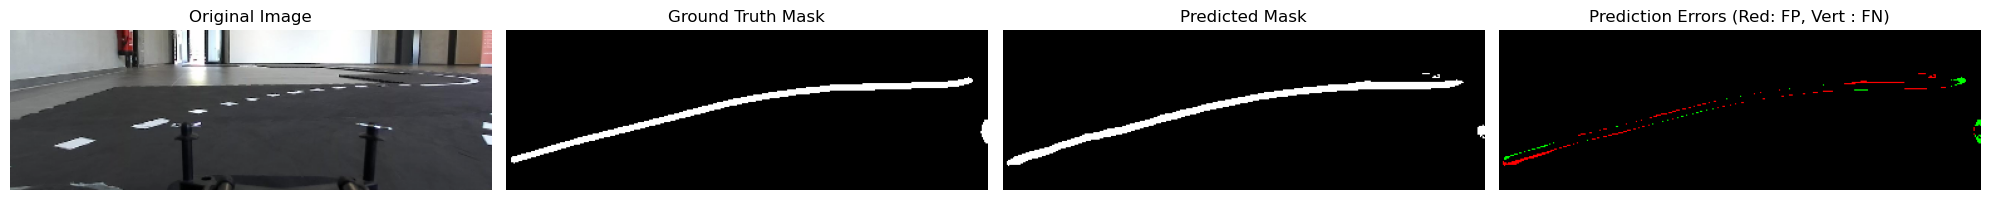

In [232]:
input_image_np = transform.to_image(preprocessed_image)
input_mask_np = transform.to_mask(preprocessed_mask)
mask_np = transform.to_mask(outputs)

fp = (mask_np == 255) & (input_mask_np == 0)
fn = (mask_np == 0) & (input_mask_np == 255)

diff_image = np.zeros((3, *input_image_np.shape[:2]), dtype=np.float32)

diff_image[0][fp] = 1.0  # Rouge pour Faux Positifs
diff_image[1][fn] = 1.0  # Vert pour Faux Négatifs

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Affichage de l'image originale
axes[0].imshow(input_image_np)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Affichage du masque réel
axes[1].imshow(input_mask_np, cmap='gray')
axes[1].set_title("Ground Truth Mask")
axes[1].axis('off')

# Affichage du masque prédit
axes[2].imshow(mask_np, cmap='gray')
axes[2].set_title("Predicted Mask")
axes[2].axis('off')

axes[3].imshow(diff_image.transpose(1, 2, 0))  # Convertir en (H, W, C) pour l'affichage
axes[3].set_title("Prediction Errors (Red: FP, Vert : FN)")
axes[3].axis('off')

# Afficher l'ensemble
plt.tight_layout()
plt.show()